# Segmentação de Clientes (Clusterização)

Projeto de Data Science e Analytics voltado para Customer Segmentation, utilizando técnicas de clusterização não supervisionada para identificar padrões de comportamento de compra e gerar insights acionáveis para Marketing, CRM e Estratégia Comercial.

O projeto aplica múltiplos algoritmos (KMeans, DBSCAN, MeanShift, Agglomerative Clustering e Gaussian Mixture) e avalia os clusters com as métricas Silhouette, Davies-Bouldin e Calinski-Harabasz.

## 1. Ambiente e Dependências

In [2]:
import numpy as np
import pandas as pd
import sidetable
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering, estimate_bandwidth
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, scale, PowerTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import gaussian_kde
from yellowbrick.cluster import kelbow_visualizer
from ipywidgets import interact

## 2. Carregamento da Base de Dados e Diagnóstico Inicial

In [52]:
df = pd.read_csv("Clustering.csv", encoding='latin1')
display(df)

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerID         Country  
0        12/1/2010 8:26       2.55     17850.0  United Kingdom  
1        12/1/2010 8:26       3.39     17850.0  United Kingdom  
2        12/1/2010 8:26       2.75     17850.0  United Kingdom  
3        12/1/2010 8:26       3.39     17850.0  United Kingdom  
4        12/1/2010 8:26       3.39     17850.0  United Kingdom  
...                 ...        ...         ...             ...  
541904  12/9/2011 12:50       0.85     12680.0          France  
541905  12/9/2011 12:50       2.10     12680.0          France  
541906  12/9/2011 12:50       4.15     12680.0          France  
541907  12/9/2011 12:50       4.15     12680.0          France  
541908  12/9/2011 12:50       4.95     12680.0          France  

[541909 rows x 8 columns]

In [53]:
# Verificando o formato dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [54]:
# Verificando se InvoiceNo é de fato um object
df.InvoiceNo.sort_values()

0          536365
1          536365
2          536365
3          536365
4          536365
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 541909, dtype: object

In [55]:
# Estatística sumária
df.describe(include='all')

InvoiceNo StockCode                         Description       Quantity  \
count     541909    541909                              540455  541909.000000   
unique     25900      4070                                4223            NaN   
top       573585    85123A  WHITE HANGING HEART T-LIGHT HOLDER            NaN   
freq        1114      2313                                2369            NaN   
mean         NaN       NaN                                 NaN       9.552250   
std          NaN       NaN                                 NaN     218.081158   
min          NaN       NaN                                 NaN  -80995.000000   
25%          NaN       NaN                                 NaN       1.000000   
50%          NaN       NaN                                 NaN       3.000000   
75%          NaN       NaN                                 NaN      10.000000   
max          NaN       NaN                                 NaN   80995.000000   

             InvoiceDate      UnitPrice     CustomerID         Country  
count             541909  541909.000000  406829.000000          541909  
unique             23260            NaN            NaN              38  
top     10/31/2011 14:41            NaN            NaN  United Kingdom  
freq                1114            NaN            NaN          495478  
mean                 NaN       4.611114   15287.690570             NaN  
std                  NaN      96.759853    1713.600303             NaN  
min                  NaN  -11062.060000   12346.000000             NaN  
25%                  NaN       1.250000   13953.000000             NaN  
50%                  NaN       2.080000   15152.000000             NaN  
75%                  NaN       4.130000   16791.000000             NaN  
max                  NaN   38970.000000   18287.000000             NaN

## 3. Limpeza e Tratamento de Dados (ETL)

In [56]:
# Verificando dados nulos e seu percentual
df.stb.missing()

missing   total    percent
CustomerID    135080  541909  24.926694
Description     1454  541909   0.268311
StockCode          0  541909   0.000000
InvoiceNo          0  541909   0.000000
Quantity           0  541909   0.000000
InvoiceDate        0  541909   0.000000
UnitPrice          0  541909   0.000000
Country            0  541909   0.000000

In [80]:
# Removendo linhas com dados nulos 
df = df.dropna()
# Conferindo novamente dados nulos
df.stb.missing()

missing   total  percent
InvoiceNo          0  397881      0.0
StockCode          0  397881      0.0
Description        0  397881      0.0
Quantity           0  397881      0.0
InvoiceDate        0  397881      0.0
UnitPrice          0  397881      0.0
CustomerID         0  397881      0.0
Country            0  397881      0.0
TotalPrice         0  397881      0.0

In [81]:
# Convertendo tipos de dados
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')

In [82]:
# Transformando InvoiceDate em datetime
pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 397881, dtype: datetime64[ns]

In [83]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30  
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00  
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
...                    ...        ...         ...             ...         ...  
541904 2011-12-09 12:50:00       0.85       12680          France       10.20  
541905 2011-12-09 12:50:00       2.10       12680          France       12.60  
541906 2011-12-09 12:50:00       4.15       12680          France       16.60  
541907 2011-12-09 12:50:00       4.15       12680          France       16.60  
541908 2011-12-09 12:50:00       4.95       12680          France       14.85  

[397881 rows x 9 columns]

In [84]:
df= df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397881 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397881 non-null  object        
 1   StockCode    397881 non-null  object        
 2   Description  397881 non-null  object        
 3   Quantity     397881 non-null  int64         
 4   InvoiceDate  397881 non-null  datetime64[ns]
 5   UnitPrice    397881 non-null  float64       
 6   CustomerID   397881 non-null  int64         
 7   Country      397881 non-null  category      
 8   TotalPrice   397881 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 27.7+ MB


In [85]:
# Limpando dados inconsistentes nas linhas onde Quantity ou UnitPrice são menores ou iguais a zero
below0 = df[['Quantity', 'UnitPrice']].le(0).any(axis=1)
df = df[~below0].copy()
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30  
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00  
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
...                    ...        ...         ...             ...         ...  
541904 2011-12-09 12:50:00       0.85       12680          France       10.20  
541905 2011-12-09 12:50:00       2.10       12680          France       12.60  
541906 2011-12-09 12:50:00       4.15       12680          France       16.60  
541907 2011-12-09 12:50:00       4.15       12680          France       16.60  
541908 2011-12-09 12:50:00       4.95       12680          France       14.85  

[397881 rows x 9 columns]

<Axes: >

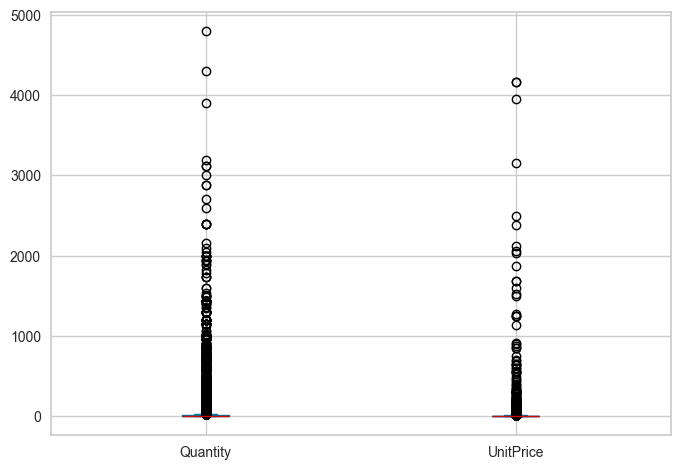

In [86]:
# Explorando os outliers com boxplot
df[['Quantity', 'UnitPrice']].plot.box()

<Axes: >

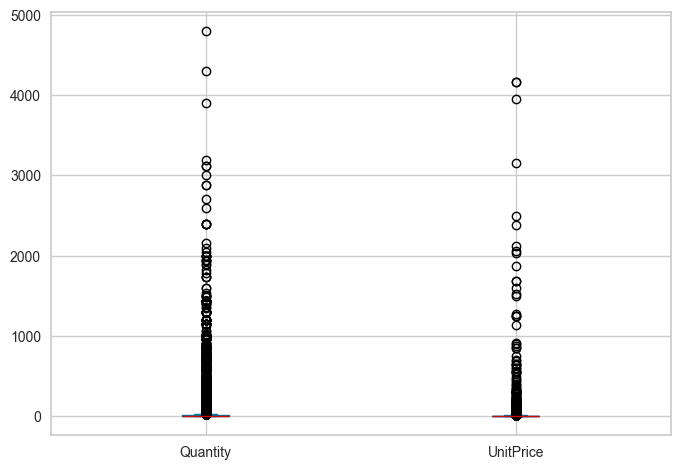

In [87]:
df.query('Quantity < 10_000')[['Quantity', 'UnitPrice']].plot.box()

In [88]:
# Selecionando os dados sem outliers
df = df.query('Quantity < 10_000 & UnitPrice < 8_000').copy()
df.describe(include='all')

InvoiceNo StockCode                         Description       Quantity  \
count     397881    397881                              397881  397881.000000   
unique     18529      3664                                3876            NaN   
top       576339    85123A  WHITE HANGING HEART T-LIGHT HOLDER            NaN   
freq         542      2035                                2028            NaN   
mean         NaN       NaN                                 NaN      12.598242   
min          NaN       NaN                                 NaN       1.000000   
25%          NaN       NaN                                 NaN       2.000000   
50%          NaN       NaN                                 NaN       6.000000   
75%          NaN       NaN                                 NaN      12.000000   
max          NaN       NaN                                 NaN    4800.000000   
std          NaN       NaN                                 NaN      42.886053   

                          InvoiceDate      UnitPrice     CustomerID  \
count                          397881  397881.000000  397881.000000   
unique                            NaN            NaN            NaN   
top                               NaN            NaN            NaN   
freq                              NaN            NaN            NaN   
mean    2011-07-10 23:41:43.181554176       3.096038   15294.426122   
min               2010-12-01 08:26:00       0.001000   12347.000000   
25%               2011-04-07 11:12:00       1.250000   13969.000000   
50%               2011-07-31 14:39:00       1.950000   15159.000000   
75%               2011-10-20 14:33:00       3.750000   16795.000000   
max               2011-12-09 12:50:00    4161.060000   18287.000000   
std                               NaN      17.938862    1713.140274   

               Country     TotalPrice  
count           397881  397881.000000  
unique              37            NaN  
top     United Kingdom            NaN  
freq            354318            NaN  
mean               NaN      21.759300  
min                NaN       0.001000  
25%                NaN       4.680000  
50%                NaN      11.800000  
75%                NaN      19.800000  
max                NaN   38970.000000  
std                NaN      95.296596

## 4. Análise Exploratória (EDA)

<Axes: ylabel='Country'>

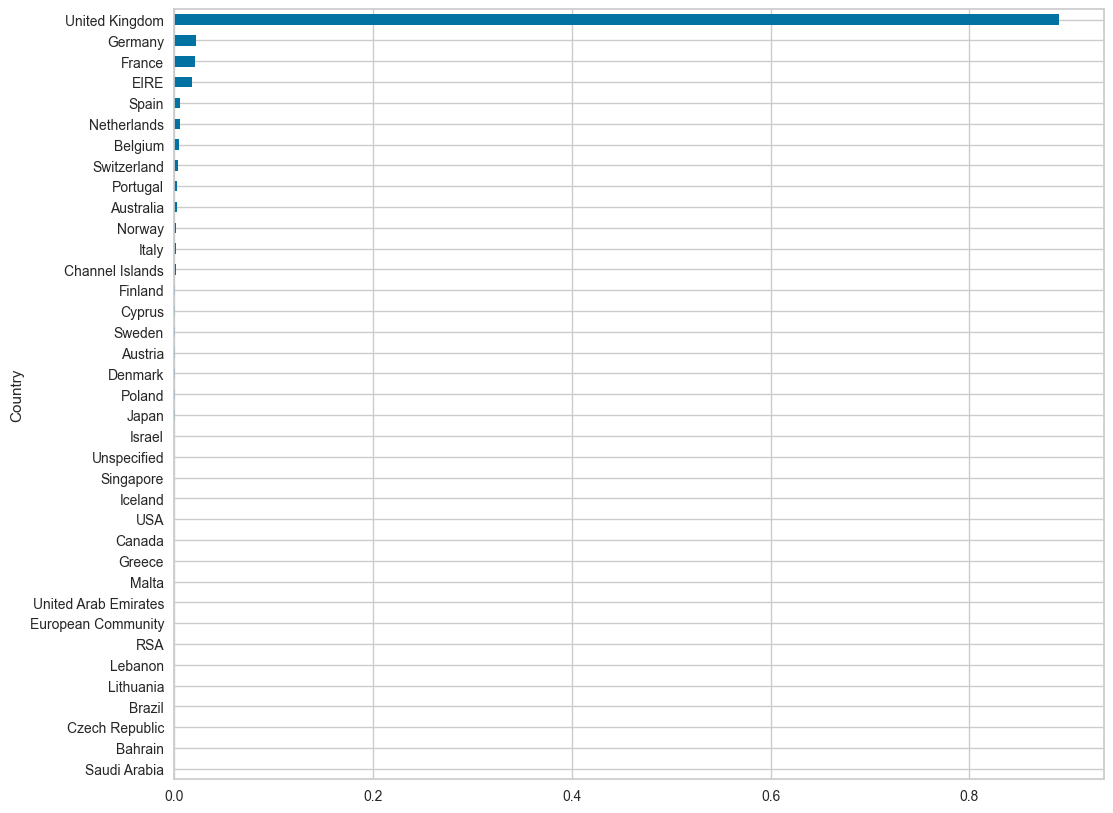

In [89]:
# 3. Visualizando a distribuição das variáveis
df['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,10))

In [90]:
# Verificando estatísticas da variável "Country"
df.stb.freq(['Country'])

c:\Users\camer\Python\Lib\site-packages\sidetable\sidetable.py:104: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_data = self._obj.groupby(cols).size().reset_index(


Country   count    percent  cumulative_count  \
0         United Kingdom  354318  89.051249            354318   
1                Germany    9040   2.272036            363358   
2                 France    8341   2.096355            371699   
3                   EIRE    7236   1.818634            378935   
4                  Spain    2484   0.624307            381419   
5            Netherlands    2359   0.592891            383778   
6                Belgium    2031   0.510454            385809   
7            Switzerland    1841   0.462701            387650   
8               Portugal    1462   0.367447            389112   
9              Australia    1182   0.297074            390294   
10                Norway    1071   0.269176            391365   
11                 Italy     758   0.190509            392123   
12       Channel Islands     748   0.187996            392871   
13               Finland     685   0.172162            393556   
14                Cyprus     614   0.154317            394170   
15                Sweden     451   0.113350            394621   
16               Austria     398   0.100030            395019   
17               Denmark     380   0.095506            395399   
18                Poland     330   0.082939            395729   
19                 Japan     321   0.080677            396050   
20                Israel     248   0.062330            396298   
21           Unspecified     244   0.061325            396542   
22             Singapore     222   0.055796            396764   
23               Iceland     182   0.045742            396946   
24                   USA     179   0.044988            397125   
25                Canada     151   0.037951            397276   
26                Greece     145   0.036443            397421   
27                 Malta     112   0.028149            397533   
28  United Arab Emirates      68   0.017091            397601   
29    European Community      60   0.015080            397661   
30                   RSA      57   0.014326            397718   
31               Lebanon      45   0.011310            397763   
32             Lithuania      35   0.008797            397798   
33                Brazil      32   0.008043            397830   
34        Czech Republic      25   0.006283            397855   
35               Bahrain      17   0.004273            397872   
36          Saudi Arabia       9   0.002262            397881   

    cumulative_percent  
0            89.051249  
1            91.323285  
2            93.419641  
3            95.238275  
4            95.862582  
5            96.455473  
6            96.965927  
7            97.428628  
8            97.796075  
9            98.093148  
10           98.362324  
11           98.552834  
12           98.740830  
13           98.912992  
14           99.067309  
15           99.180660  
16           99.280689  
17           99.376195  
18           99.459135  
19           99.539812  
20           99.602142  
21           99.663467  
22           99.719263  
23           99.765005  
24           99.809993  
25           99.847944  
26           99.884388  
27           99.912537  
28           99.929627  
29           99.944707  
30           99.959033  
31           99.970343  
32           99.979139  
33           99.987182  
34           99.993465  
35           99.997738  
36          100.000000

In [91]:
# Entendendo qual o período dos dados
df.InvoiceDate.agg(['min', 'max'])

min   2010-12-01 08:26:00
max   2011-12-09 12:50:00
Name: InvoiceDate, dtype: datetime64[ns]

## 5. Feature Engineering: Construção de RFM

Para transformar dados transacionais em variáveis adequadas para segmentação, aplico a abordagem clássica de **RFM**:

- **Recency (R):** há quanto tempo o cliente comprou pela última vez  
- **Frequency (F):** quantas compras o cliente realizou  
- **Monetary (M):** quanto o cliente gastou no total  

Como os algoritmos de clusterização são sensíveis à escala, aplico técnicas de padronização e transformação para:

- reduzir distorções por magnitude (ex.: Monetary dominar tudo)
- melhorar a separação dos clusters
- estabilizar distribuições (reduzindo assimetria)

In [92]:
# Criando a variável TotalPrice
df['TotalPrice'] = df.Quantity * df.UnitPrice
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30  
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00  
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
...                    ...        ...         ...             ...         ...  
541904 2011-12-09 12:50:00       0.85       12680          France       10.20  
541905 2011-12-09 12:50:00       2.10       12680          France       12.60  
541906 2011-12-09 12:50:00       4.15       12680          France       16.60  
541907 2011-12-09 12:50:00       4.15       12680          France       16.60  
541908 2011-12-09 12:50:00       4.95       12680          France       14.85  

[397881 rows x 9 columns]

In [ ]:
# Criando as variáveis RFM - Recência, Frequência e Monetário
df_rfm = (
    df.groupby('CustomerID')
    .agg(
        R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days), # Utilizando 01/01/2012 como data de referência (dia seguinte ao último registro da base 31/12/2011)
        F = ('InvoiceNo', 'nunique'), 
        M = ('TotalPrice', 'mean') 
         )
)
df_rfm

R   F          M
CustomerID                    
12347        24   7  23.681319
12348        97   4  57.975484
12349        40   1  24.076027
12350       332   1  19.670588
12352        58   8  29.482824
...         ...  ..        ...
18280       299   1  18.060000
18281       202   1  11.545714
18282        29   2  14.837500
18283        25  16   2.771005
18287        64   3  26.246857

[4337 rows x 3 columns]

<Axes: >

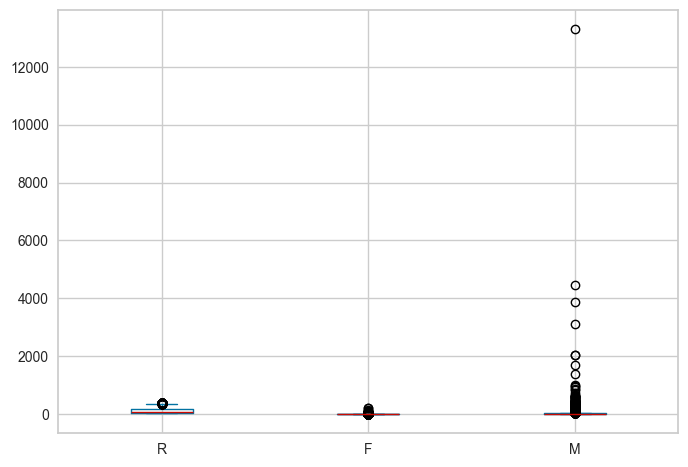

In [94]:
# Visualizando os outliers em RFM
df_rfm.plot.box()

<Axes: >

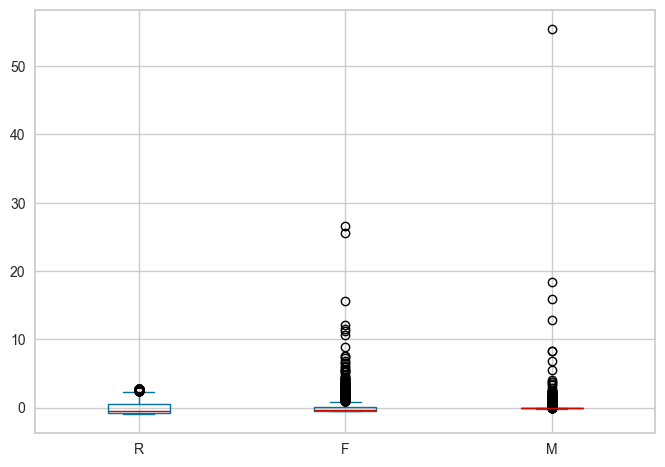

In [95]:
# Normalizando os dados com scale
df_rfm.apply(scale).plot.box()

In [96]:
# Identificando o cliente com M > 50 (outlier)
df_rfm.apply(scale).query('M > 50')

R         F          M
CustomerID                               
15098       0.899878 -0.165317  55.434876

In [97]:
# Consultando o cliente com M > 50
df.query('CustomerID == 15098')

InvoiceNo StockCode                     Description  Quantity  \
222670    556442     22502      PICNIC BASKET WICKER SMALL        60   
222680    556444     22502  PICNIC BASKET WICKER 60 PIECES        60   
222682    556446     22502  PICNIC BASKET WICKER 60 PIECES         1   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
222670 2011-06-10 15:22:00       4.95       15098  United Kingdom       297.0  
222680 2011-06-10 15:28:00     649.50       15098  United Kingdom     38970.0  
222682 2011-06-10 15:33:00     649.50       15098  United Kingdom       649.5

In [98]:
# Excluindo o cliente com M > 50
df_rfm = df_rfm.drop(15098)

<Axes: >

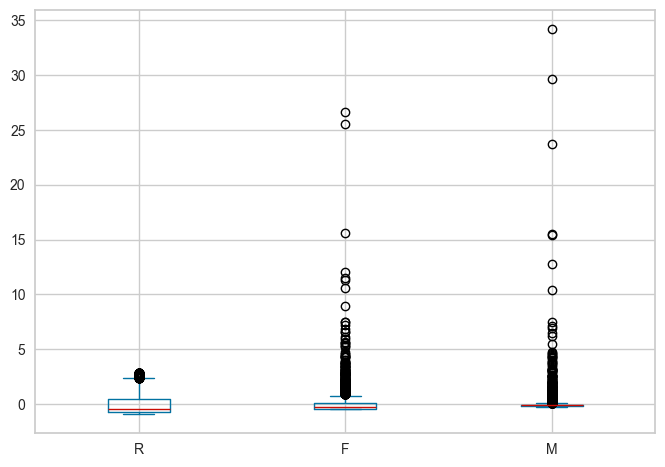

In [99]:
# Verificando boxplot após remoção do outlier M > 50
df_rfm.apply(scale).plot.box()

In [100]:
# Transformando os dados com PowerTransform (media 0 DP 1) e transformando em DataFrame
scaler = PowerTransformer()
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled

R         F         M
CustomerID                              
12347      -1.563219  1.201866  0.407836
12348       0.323470  0.660670  1.329304
12349      -0.809134 -1.158070  0.426829
12350       1.568467 -1.158070  0.189376
12352      -0.307718  1.309671  0.653411
...              ...       ...       ...
18280       1.475652 -1.158070  0.085562
18281       1.107356 -1.158070 -0.491003
18282      -1.275046 -0.195707 -0.161007
18283      -1.500181  1.750302 -2.606380
18287      -0.181363  0.327225  0.524778

[4336 rows x 3 columns]

<Axes: >

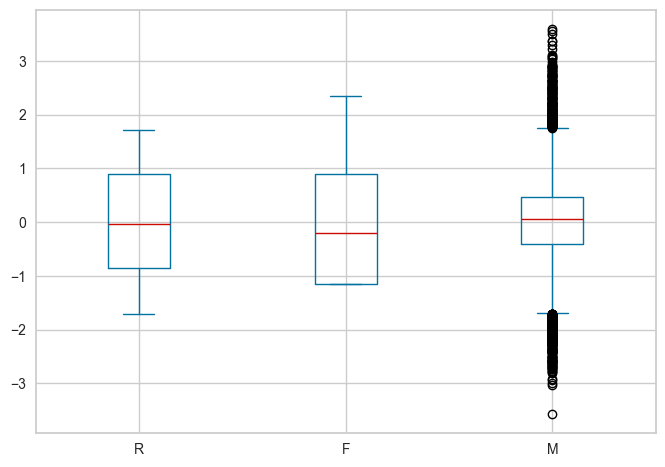

In [101]:
# Visualizando os dados normalizados
df_rfm_scaled.plot.box()

In [102]:
df_rfm.describe()

R            F            M
count  4336.000000  4336.000000  4336.000000
mean    114.032288     4.272601    34.554185
std      99.968352     7.697927   129.202663
min      22.000000     1.000000     1.450000
25%      39.000000     1.000000    12.339095
50%      72.000000     2.000000    17.715999
75%     163.250000     5.000000    24.843993
max     395.000000   209.000000  4453.430000

In [103]:
# Clipando dados extremos
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(0.95)))
df_rfm_clip.describe()

R            F            M
count  4336.000000  4336.000000  4336.000000
mean    112.248155     3.608164    23.634656
std      95.504576     3.358999    20.993635
min      22.000000     1.000000     1.450000
25%      39.000000     1.000000    12.339095
50%      72.000000     2.000000    17.715999
75%     163.250000     5.000000    24.843993
max     333.000000    13.000000    91.768421

In [104]:
df_rfm_clip_scaled = df_rfm_clip.apply(scale)

## 6. Modelagem: Clusterização Não Supervisionada

Nesta etapa, aplico diferentes algoritmos de clusterização para comparar abordagens com diferentes princípios matemáticos:
- **KMeans:** clusterização baseada em centróides  
- **DBSCAN:** clusterização por densidade (detecta ruído/outliers)  
- **MeanShift:** clusterização por densidade adaptativa  
- **Agglomerative Clustering:** clusterização hierárquica  
- **Gaussian Mixture Model (GMM):** clusterização probabilística
O objetivo é identificar qual método gera segmentos mais coerentes, separáveis e úteis para o negócio.

Como clusterização não possui target, a avaliação depende de métricas internas que medem separação e coesão:
- **Silhouette Score:** quanto cada ponto está bem posicionado dentro do cluster  
- **Davies-Bouldin:** penaliza clusters sobrepostos (quanto menor, melhor)  
- **Calinski-Harabasz:** mede separação global entre clusters (quanto maior, melhor)
Essas métricas ajudam a comparar modelos e escolher a segmentação mais consistente.

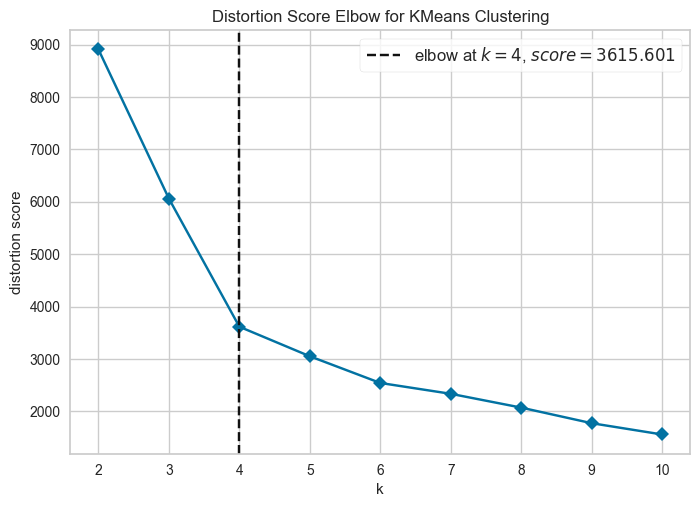

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [34]:
# Criando o Modelo KMeans

# Definindo o número ideal de k usando método do cotovelo (Elbow Method)
kelbow_visualizer(KMeans(), df_rfm_clip_scaled, k=10, timings=False)

In [ ]:
# Definindo o número ideal de k usando os métodos Silhouette Score, Davies Bouldin Score e Calinski Harasz Score
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score 
cluster_metrics_results = [] 
X = df_rfm_clip_scaled.copy()

for k in range (2, 11):
    model = KMeans(n_clusters=k) 
    labels = model.fit_predict(X) 
    cluster_results_dict = {'k': k} 
    cluster_results_dict['inertia'] = model.inertia_ 
    for metric in cluster_metrics: 
        cluster_results_dict[metric.__name__] = metric(X, labels) 
    cluster_metrics_results.append(cluster_results_dict) 

In [36]:
pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()
# Interpretação -> silhouette e calinski = quanto maior melhor, davies = quanto menor melhor

In [37]:
# Criando o modelo KMeans com k=4
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(df_rfm_clip_scaled)

In [66]:
# Plotando os clusters em 3D
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

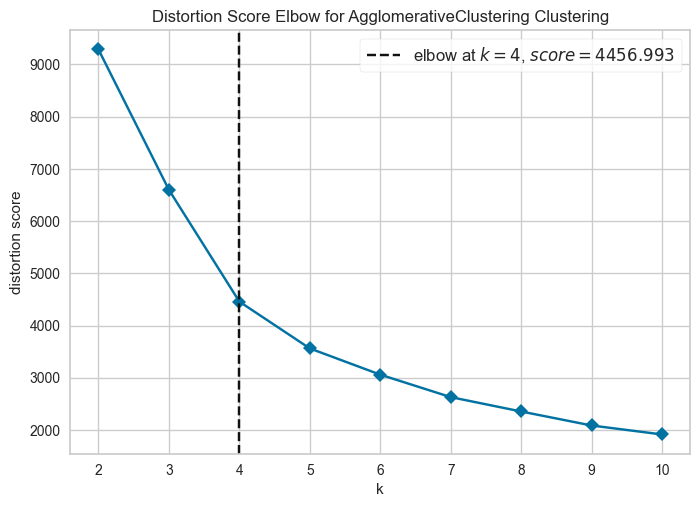

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [40]:
# Criando o Modelo Hierarquico (Agglomerative Clustering)

# Definindo o número ideal de k usando método do cotovelo (Elbow Method)
kelbow_visualizer(AgglomerativeClustering(), df_rfm_clip_scaled, k=10, timings=False)

In [ ]:
# Definindo o número ideal de k usando os métodos Silhouette Score, Davies Bouldin Score e Calinski Harasz Score
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score 
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range (2, 11):
    model = AgglomerativeClustering(n_clusters=k) 
    labels = model.fit_predict(X)
    cluster_results_dict = {'k': k}
    for metric in cluster_metrics:
        cluster_results_dict[metric.__name__] = metric(X, labels) 
    cluster_metrics_results.append(cluster_results_dict)

In [42]:
pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

In [43]:
# Criando o modelo Hierárquico com k=4
hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(df_rfm_clip_scaled)  

In [67]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

In [ ]:
# Criando o Modelo Gaussian Mixture

# Seleção do melhor modelo pela análise dos tipos de covariancia e k
results = []
k_range = range(1,10)
covariance_types = ['full', 'tied', 'diag', 'spherical'] 
X = df_rfm_clip_scaled.copy()

for n_components in k_range:
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)
        mclust.fit(X)
        results.append({
            'bic': mclust.bic(X), 
            'n_components': n_components, 
            'covariance_type': covariance_type, 
        })

results = pd.DataFrame(results)
results.sort_values('bic').head() 
# Interpretação: melhores resultados são os menores valores de BIC

bic  n_components covariance_type
32 -4156.871346             9            full
34  -263.079152             9            diag
28   -47.528888             8            full
26   211.361244             7            diag
30  6915.342139             8            diag

<Axes: xlabel='n_components', ylabel='bic'>

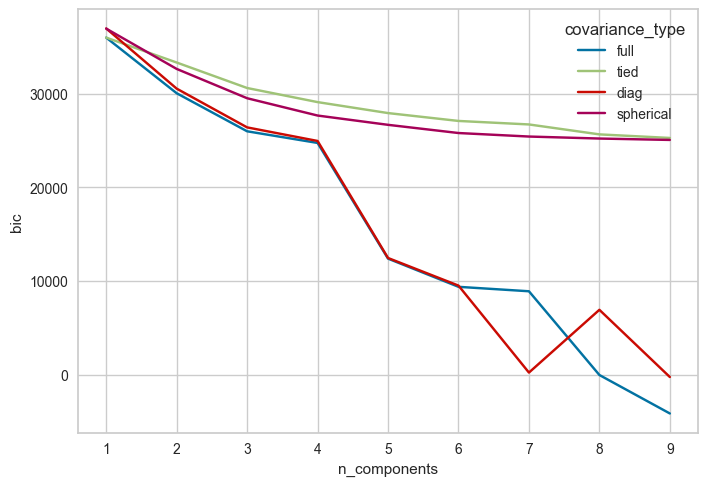

In [45]:
# Avaliando os resultados do BIC visualmente
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type')

In [47]:
# Criando o modelo Gaussian Mixture com k=9 e covariancia diagonal
mclust = GaussianMixture(n_components=9, covariance_type='diag', n_init = 10)
mclust_labels = mclust.fit_predict(df_rfm_clip_scaled)

In [68]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=mclust_labels.astype(str), template='plotly_dark')

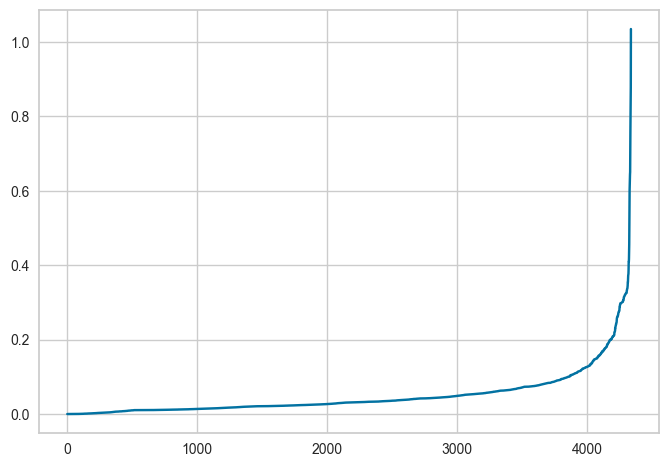

In [48]:
# Criando o Modelo DBSCAN

# Definindo o eps com base na distribuição das distâncias aos vizinhos mais próximos
# Adaptado de https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
nn_model = NearestNeighbors(n_neighbors=2).fit(X)
distances, indices = nn_model.kneighbors(X)
distances = np.sort(distances, axis=0)
plt.plot(distances[:,1])
plt.show()

In [69]:
# Definindo o eps e min_sample iterativamente
@interact(eps=(0.01, 1, 0.01), min_samples=(1, 100))
def custom_dbscan(eps, min_samples):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = model.fit_predict(X)
    
    # Criando DataFrame
    df_plot = pd.DataFrame(X, columns=['R', 'F', 'M'])
    df_plot['cluster'] = dbscan_labels.astype(str)
    
    fig = px.scatter_3d(df_plot, x='R', y='F', z='M', color='cluster', template='plotly_dark')
    fig.show()

interactive(children=(FloatSlider(value=0.5, description='eps', max=1.0, min=0.01, step=0.01), IntSlider(value…

In [51]:
# Criando o Modelo Mean Shift

X = df_rfm_clip_scaled.copy()
ms = MeanShift()
ms.fit(X)
ms_labels = ms.labels_
cluster_centers = ms.cluster_centers_

In [52]:
# Adicionando coluna 'cluster' ao DataFrame X
X['cluster'] = ms_labels.astype(str)

In [53]:
# Plotando a densidade KDE 3D com isosuperfície

# Preparando os dados para KDE
data = X[['R', 'F', 'M']].to_numpy().T

# Estimando KDE
kde = gaussian_kde(data)

# Criando grid 3D para avaliação da densidade
xmin, ymin, zmin = data.min(axis=1)
xmax, ymax, zmax = data.max(axis=1)

xgrid = np.linspace(xmin, xmax, 50)
ygrid = np.linspace(ymin, ymax, 50)
zgrid = np.linspace(zmin, zmax, 50)

xv, yv, zv = np.meshgrid(xgrid, ygrid, zgrid)

# Avaliando KDE no grid
positions = np.vstack([xv.ravel(), yv.ravel(), zv.ravel()])
density = kde(positions).reshape(xv.shape)

# Definindo um nível para isosuperfície (densidade de corte)
iso_level = np.percentile(density, 90) 

# Plotar isosuperfície KDE 3D no plotly
fig = go.Figure(data=go.Isosurface(
    x=xv.flatten(),
    y=yv.flatten(),
    z=zv.flatten(),
    value=density.flatten(),
    isomin=iso_level,
    isomax=density.max(),
    surface_count=3,
    caps=dict(x_show=False, y_show=False, z_show=False),
    colorscale='Viridis',
    opacity=0.6,
))

fig.update_layout(scene=dict(
    xaxis_title='R',
    yaxis_title='F',
    zaxis_title='M'
))

fig.show()

In [70]:
# Criando scatter 3D dos pontos
fig = px.scatter_3d(X, x='R', y='F', z='M', color='cluster', template='plotly_dark')

# Adicionando centróides como diamantes
centers_df = pd.DataFrame(cluster_centers, columns=['R', 'F', 'M'])
fig.add_trace(go.Scatter3d(
    x=centers_df['R'],
    y=centers_df['F'],
    z=centers_df['M'],
    mode='markers',
    marker=dict(
        size=15,
        symbol='diamond',
        color='red',
        line=dict(color='white', width=2)
    ),
    name='Centróides',
    showlegend=True
))

fig.show()

In [55]:
# Definindo o bandwidth iterativamente

@interact(bandwidth=(0.1, 3, 0.01))
def custom_meanshift(bandwidth):
    model = MeanShift(bandwidth=bandwidth, cluster_all=True)
    ms_labels = model.fit_predict(X)
    
    # Preparando os dados para plotagem
    X_plot = X.copy()
    X_plot['cluster'] = ms_labels.astype(str)
    
    # Criando scatter 3D dos pontos
    fig = go.Figure()
    
    # Plotar pontos coloridos por cluster
    for cluster in X_plot['cluster'].unique():
        cluster_data = X_plot[X_plot['cluster'] == cluster]
        fig.add_trace(go.Scatter3d(
            x=cluster_data['R'],
            y=cluster_data['F'],
            z=cluster_data['M'],
            mode='markers',
            marker=dict(size=3),
            name=f'Cluster {cluster}'
        ))
    
    # Adicionando centróides
    centers = model.cluster_centers_
    fig.add_trace(go.Scatter3d(
        x=centers[:, 0],
        y=centers[:, 1],
        z=centers[:, 2],
        mode='markers',
        marker=dict(
            size=15,
            symbol='diamond',
            color='red',
            line=dict(color='white', width=2)
        ),
        name='Centróides'
    ))
    
    # Configurando layout
    fig.update_layout(
        scene=dict(
            xaxis_title='R',
            yaxis_title='F',
            zaxis_title='M'
        ),
        template='plotly_dark',
        title=f'MeanShift Clustering (bandwidth={bandwidth:.2f})'
    )
    
    fig.show()

interactive(children=(FloatSlider(value=1.55, description='bandwidth', max=3.0, min=0.1, step=0.01), Output())…

## 7. Comparando os modelos através das métricas de Silhouette Score, Davies-Bouldin e Calinski-Harabasz


In [ ]:
 # Criando o modelo DBSCAN com eps=0.5 e min_samples=5 conforme definido iterativamente
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

#Avaliando os modelos

def avaliar_modelo_clusterizacao(X, labels, nome_modelo):

    # Ignorar ruído (-1) no DBSCAN
    labels_validos = labels[labels != -1]
    X_validos = X[labels != -1]

    n_clusters = len(set(labels_validos))
    n_ruido = int((labels == -1).sum())

    if n_clusters < 2:
        return {
            "modelo": nome_modelo,
            "n_clusters": n_clusters,
            "n_ruido": n_ruido,
            "silhouette_score": None,
            "davies_bouldin_score": None,
            "calinski_harabasz_score": None
        }

    return {
        "modelo": nome_modelo,
        "n_clusters": n_clusters,
        "n_ruido": n_ruido,
        "silhouette_score": silhouette_score(X_validos, labels_validos),
        "davies_bouldin_score": davies_bouldin_score(X_validos, labels_validos),
        "calinski_harabasz_score": calinski_harabasz_score(X_validos, labels_validos)
    }


# Construindo tabela comparativa
resultados_modelos = []

resultados_modelos.append(avaliar_modelo_clusterizacao(X.values, kmeans_labels, "KMeans"))
resultados_modelos.append(avaliar_modelo_clusterizacao(X.values, dbscan_labels, "DBSCAN"))
resultados_modelos.append(avaliar_modelo_clusterizacao(X.values, ms_labels, "MeanShift"))
resultados_modelos.append(avaliar_modelo_clusterizacao(X.values, hclust_labels, "AgglomerativeClustering"))
resultados_modelos.append(avaliar_modelo_clusterizacao(X.values, mclust_labels, "GaussianMixture"))

tabela_comparativa = pd.DataFrame(resultados_modelos)

# Ordenando pelo Silhouette (maior = melhor)
tabela_comparativa = tabela_comparativa.sort_values("silhouette_score", ascending=False)

tabela_comparativa



modelo  n_clusters  n_ruido  silhouette_score  \
2                MeanShift           3        0          0.476600   
0                   KMeans           4        0          0.472353   
1                   DBSCAN           4       28          0.450943   
3  AgglomerativeClustering           4        0          0.431873   
4          GaussianMixture           9        0          0.013673   

   davies_bouldin_score  calinski_harabasz_score  
2              0.861806              1426.611186  
0              0.757366              3476.587361  
1              0.802748               946.826881  
3              0.806129              2628.508065  
4              2.084654               853.058940

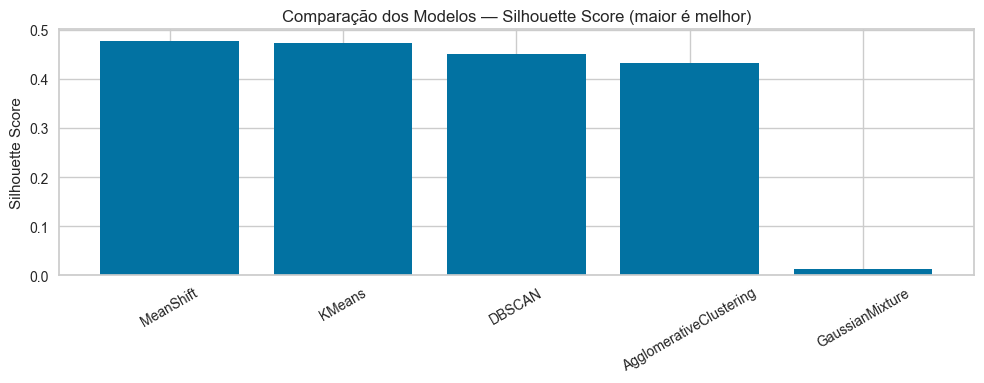

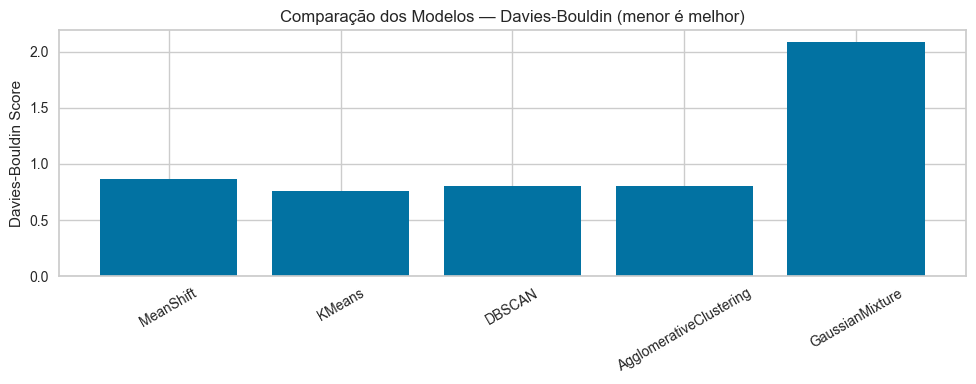

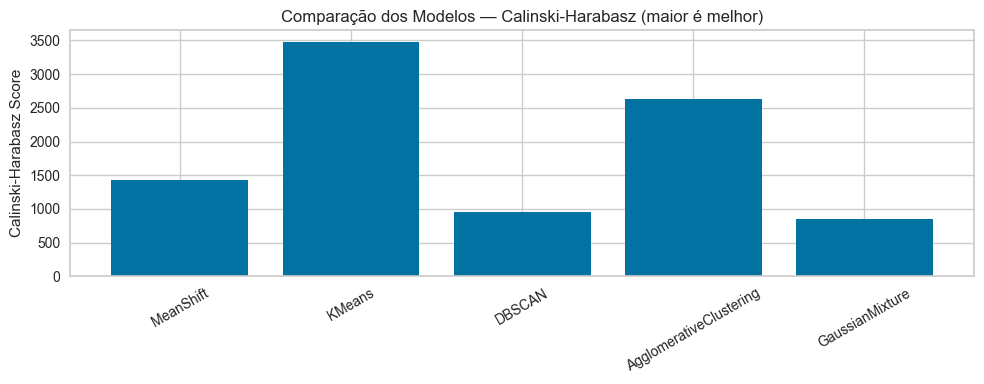

In [65]:
#  Visualização comparativa

# Silhouette Score (maior = melhor)
plt.figure(figsize=(10, 4))
plt.bar(tabela_comparativa["modelo"], tabela_comparativa["silhouette_score"])
plt.title("Comparação dos Modelos — Silhouette Score (maior é melhor)")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Davies-Bouldin (menor = melhor)
plt.figure(figsize=(10, 4))
plt.bar(tabela_comparativa["modelo"], tabela_comparativa["davies_bouldin_score"])
plt.title("Comparação dos Modelos — Davies-Bouldin (menor é melhor)")
plt.ylabel("Davies-Bouldin Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Calinski-Harabasz (maior = melhor)
plt.figure(figsize=(10, 4))
plt.bar(tabela_comparativa["modelo"], tabela_comparativa["calinski_harabasz_score"])
plt.title("Comparação dos Modelos — Calinski-Harabasz (maior é melhor)")
plt.ylabel("Calinski-Harabasz Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


### O KMEANS foi selecionado como o melhor modelo

## 7. Análise dos clusters obtidos pelo modelo KMeans

In [71]:
# Armazenando os centroides
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)
centers

R         F         M
0 -0.740690  1.960061 -0.152811
1  1.559673 -0.624632 -0.263435
2 -0.467918 -0.269498 -0.311006
3  0.090675  0.079261  2.715581

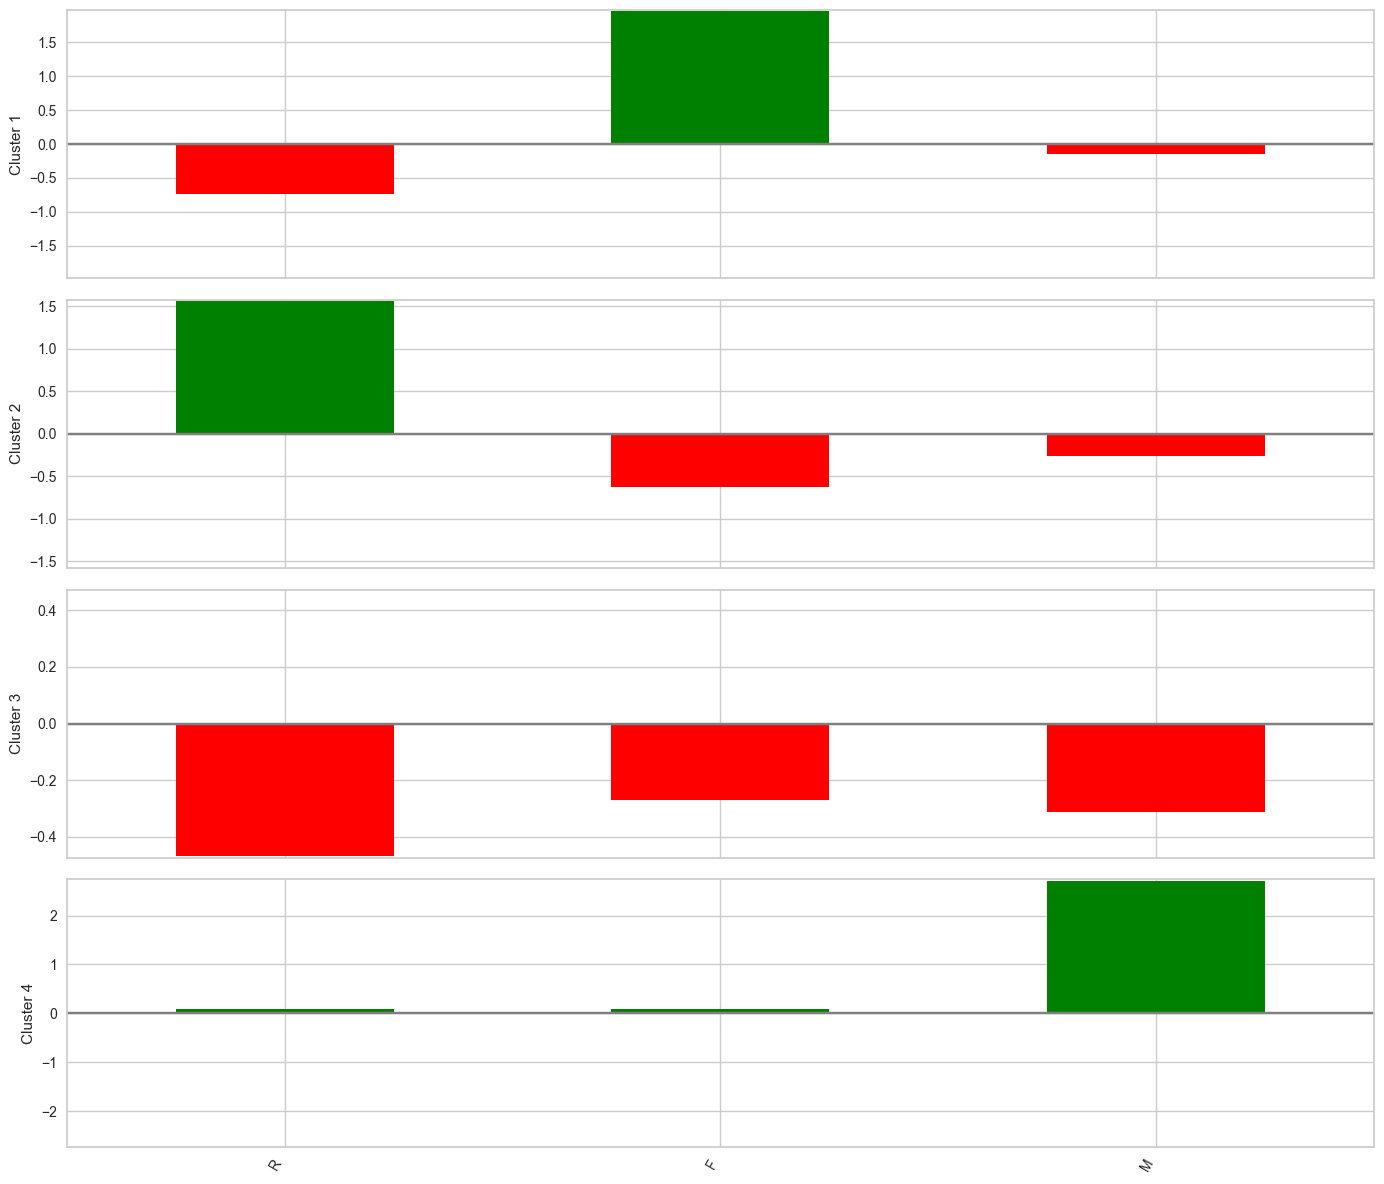

In [72]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none') 

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [74]:
# Plotando os dados descritivos dos clusters
(
  df_rfm_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

### Com base na tabela RFM apresentada, é possível descrever cada cluster de clientes e sugerir estratégias de gestão personalizadas para cada segmento.


**Cluster 0:**
Recência baixa (41,52): clientes compraram há pouco tempo.
Frequência alta (10,19): clientes que compram frequentemente.
Valor médio (20,43): valor médio das compras.
Perfil: clientes engajados e regulares, fazem compras recentes e com boa frequência.

**Cluster 1:**
Recência elevada (261,20): estão inativos há bastante tempo.
Frequência muito baixa (1,51): fizeram poucas compras.
Valor intermediário (18,03): valor médio das compras.
Perfil: clientes inativos, fizeram poucas compras há muito tempo.

**Cluster 2:**
Recência intermediária (67,53): clientes não tão recentes, mas ainda ativos.
Frequência baixa (2,70): compram com baixa frequência.
Valor intermediário (17,11): valor moderado por compra.
Perfil: clientes ocasionais, fazem compras esporádicas.

**Cluster 3:**
Recência intermediária/alta (121,32): clientes que compraram há um tempo considerável, mas não estão totalmente inativos.
Frequência baixa (3,86): compras pouco frequentes.
Valor alto (80,50): alto valor total gasto.
Perfil: clientes valiosos, gastaram bastante, mesmo comprando pouco e não sendo tão recentes.

## 8. Conclusão e Insights para o Negócio

A segmentação construída permite aplicações diretas em cenários reais, como:

- campanhas personalizadas (CRM)
- estratégias de retenção e reativação
- identificação de clientes de alto valor (VIP)
- detecção de clientes com baixa recorrência (risco de churn)
- melhoria de LTV (Lifetime Value)

Além disso, a comparação entre múltiplos algoritmos fortalece a robustez do projeto e demonstra capacidade analítica aplicada.
